In [39]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

## Helper Functions

In [40]:
# Preprocessing Functions
def handle_nan(df, method='bfill'):
    ## Fill NaN values with the earliest data
    if method == 'bfill':
        return df.fillna(method='bfill', axis=0)
    elif method == 'zerofill':
        return df.fillna(0)
    elif method == 'drop':
        return df.dropna()

def extend_price_df(df):
    '''
    Calculates returns, log_returns, and log_prices to a df with 'price' column
    '''
    df['log-price'] = np.log(df['price'])
    df['return'] = df['price'].pct_change()
    df['log-return'] = np.log(1 + df['return'])
    
    df = handle_nan(df, method='zerofill')
    
    return df
     
def gen_combined_df(df_dict, dict_keys, col, nan_handle_method='bfill', add_pfix=True):
    for i, key in enumerate(dict_keys):
        if i == 0:
            df_buff = pd.DataFrame(index=df_dict[key].index)
        for c in col:
            if add_pfix:
                df_buff[key + '_' + c] = df_dict[key][c]
            else:
                df_buff[key] = df_dict[key][c]
    
    # Handle NaN values from combination of multiple tickers
    # Assumes that NaN values because "stock have not existed" has been handled
    df_buff = handle_nan(df_buff, method=nan_handle_method)
    df_buff = handle_nan(df_buff, method='drop')
            
    return df_buff

# Plotting Functions
def tsplot(y, lags=None, figsize=(20, 8), style='bmh', title='Time Series Analysis Plots'):
    # source: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=False, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, zero=False, auto_ylims=True)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Data Preparation

### Data Loading

In [3]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

## Prepare active tickers for international codes
active_tickers = [f + '.JK' for f in lq45_tickers]
active_tickers.append('LQ45')

In [4]:
# Prepare Time Series Data
# TODO - Returns calculation need to be done after fill
nan_handle_method = 'bfill'

df_dict = {}
for ticker in tqdm(active_tickers):
    if ticker == 'LQ45':
        df_dict[ticker] = pd.read_csv(lq45_index_file)
    else:
        df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
    ## Take Only Date and Adjusted Close
    df_dict[ticker] = df_dict[ticker][['Date', 'Adj Close']]
    df_dict['Date'] = pd.to_datetime(df_dict[ticker]['Date'])
    df_dict[ticker].set_index(pd.DatetimeIndex(df_dict[ticker]['Date']), inplace=True)
    
    df_dict[ticker].drop('Date', axis=1, inplace=True)
    
    ## Convert Adj Close to price
    df_dict[ticker]['price'] = df_dict[ticker]['Adj Close']
    df_dict[ticker].drop('Adj Close', axis=1, inplace=True)

100%|█████████████████████████████████████████████████████| 46/46 [00:01<00:00, 34.91it/s]


In [5]:
# Separate Into In Sample and Out Sample
date_start = '2010-01-01'
date_breakpoint = '2019-01-01'

nan_cnt_threshold = 252*2

in_df = {}
out_df = {}
rmv_tickers = []
for ticker in tqdm(active_tickers):
    ## Take In Sample and Out Sample Data
    in_df[ticker] = df_dict[ticker][(df_dict[ticker].index >= date_start) & 
                                                (df_dict[ticker].index < date_breakpoint)]
    out_df[ticker] = df_dict[ticker][df_dict[ticker].index >= date_breakpoint]
    
    ## Check if there are too many NaN values
    if in_df[ticker]['price'].isna().sum() > nan_cnt_threshold:
        rmv_tickers.append(ticker)
        continue
    
    ## Handle NaN Values
    in_df[ticker] = handle_nan(in_df[ticker], method=nan_handle_method)
    out_df[ticker] = handle_nan(out_df[ticker], method=nan_handle_method)
    
    ## Extend price to other values
    in_df[ticker] = extend_price_df(in_df[ticker])
    out_df[ticker] = extend_price_df(out_df[ticker])

# Remove tickers that only have small amounts of data
active_tickers = [t for t in active_tickers if t not in rmv_tickers]

100%|█████████████████████████████████████████████████████| 46/46 [00:00<00:00, 64.89it/s]


## Data Exploration
Cointegration exploration is done on in-sample data only, so out of sample data is purely for testing.

*We will revisit cointegration testing on OOS data later on.

Steps:
- Test using existing engle-granger package. 
- Fit Ornstein-Uhlenbeck process to generate lambda (and subsequently, half life)
- Do a separate OLS to get beta of (potentially) cointegrating pair. Visualize Mean Reversion to verify.

### Engle-Granger Cointegration Test

In [6]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller

def find_coint_pairs(df_dict, tickers, form='normal', form_type='price', alpha=0.05):
    '''
    Finds cointegrated pairs from df_dict serial data, based on given tickers.
    '''
    def coint_ticker_pick(pvalue_1, pvalue_2, tickers, i, j):
        if pvalue_1 <= pvalue_2:
            pvalue = pvalue_1
            coint_tickers = [tickers[i], tickers[j]]
        else:
            pvalue = pvalue_2
            coint_tickers = [tickers[j], tickers[i]]
        
        return pvalue, coint_tickers
    
    n = len(tickers)
    pairs = []
    pvalues = []
    
    for i in range(0, n):
        for j in range(i+1, n):
            
            comb_df = gen_combined_df(df_dict, [tickers[i], tickers[j]], [form_type])
            S1 = comb_df[tickers[i] + "_" + form_type]
            S2 = comb_df[tickers[j] + "_" + form_type]
                
            if(form == 'normal'):
                result_1 = coint(S2, S1)
                pvalue_1 = result_1[1]
                
                result_2 = coint(S1, S2)
                pvalue_2 = result_2[1]
                
                pvalue, coint_tickers = coint_ticker_pick(pvalue_1, pvalue_2, tickers, i, j)
                
            elif(form == 'ratio'):
                result_1 = adfuller(S1/S2)
                pvalue_1 = result_1[1]
                
                result_2 = adfuller(S2/S1)
                pvalue_2 = result_2[1]
                
                pvalue, coint_tickers = coint_ticker_pick(pvalue_1, pvalue_2, tickers, i, j)
                
            if pvalue < alpha:
                pairs.append(coint_tickers)
                pvalues.append(pvalue)
                      
    return pairs, pvalues

def calc_beta_ols(S2, S1, form_type='price'):
    '''
    Calculate beta from two series by doing regression.
    '''
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[form_type]
    b = results.params[form_type].values[0]
    
    return b

def calc_half_life(S, form_type='price'):
    '''
    Calculate half life from a price series
    '''
    S_lag = S.shift(periods=1).iloc[1:]
    S_diff = S.iloc[1:] - S_lag

    S_lag = sm.add_constant(S_lag)
    results = sm.OLS(S_diff, S_lag).fit()
    S_lag = S_lag[form_type]
    lbd = results.params[form_type].values[0]

    hl = -np.log(2) / lbd
    
    return hl, lbd

In [7]:
# Prepare LQ45 Stock Indexes of the Same Group
stock_groups = {
    "energy_and_mining": ['BRPT.JK', 'HRUM.JK', 'MEDC.JK', 'PGAS.JK', 'TPIA.JK', 'ADRO.JK', 'ITMG.JK', 'PTBA.JK', 'INCO.JK', 'MDKA.JK', 'ANTM.JK'],
    "retail": ['AMRT.JK', 'UNVR.JK', 'ERAA.JK', 'ASII.JK'],
    "food_agri": ['CPIN.JK', 'JPFA.JK', 'ICBP.JK', 'INDF.JK'],
    "paper": ['TKIM.JK', 'INKP.JK'],
    "finance": ['BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BFIN.JK'],
    "media": ['EMTK.JK', 'MNCN.JK'],
    "telcom": ['EXCL.JK', 'TLKM.JK', 'TBIG.JK', 'TOWR.JK'],
    "tobacco": ['GGRM.JK', 'HMSP.JK'],
    "construction": ['INTP.JK', 'PTPP.JK', 'SMGR.JK', 'UNTR.JK', 'WIKA.JK', 'WSKT.JK'],
    "medical": ['KLBF.JK', 'MIKA.JK']
}

# Filter to only those that are active
for key, val in stock_groups.items():
    stock_groups[key] = [t for t in val if t in active_tickers]

In [8]:
# Search for Coint Pair on Different Forms
forms = ['normal', 'ratio']
form_types = ['price', 'log-price']

pair_l = []
for key, val in tqdm(stock_groups.items()):
    tickers = val
    tickers.append('LQ45')
    
    for f in forms:
        for ft in form_types:
    
            pairs, pvalues = find_coint_pairs(in_df, tickers, form=f, form_type=ft, alpha=0.025)
            for pair, pvalue in zip(pairs, pvalues):
                pair_l.append({
                                'ticker_1': pair[0],
                                'ticker_2': pair[1],
                                'form': f,
                                'form_type': ft,
                                'eg_pvalue': pvalue
                            })
    
pair_df = pd.DataFrame(pair_l) 

100%|█████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.64s/it]


In [9]:
# Calculate Half-Life

pair_l = []
for _, row in pair_df.iterrows():
    # Regression to get Beta for Price Spread Model
    ## Combine Series
    comb_df = gen_combined_df(in_df, [row['ticker_1'], row['ticker_2']], [row['form_type']])
    
    ## Rename Columns
    S1 = comb_df[row['ticker_1'] + "_" + row['form_type']]
    S1.name = row['form_type']
    S2 = comb_df[row['ticker_2'] + "_" + row['form_type']]
    S2.name = row['form_type']
    
    if row['form'] == 'normal':
        b = calc_beta_ols(S2, S1, form_type=[row['form_type']])
        spread = S2 - b * S1
        
    elif row['form'] == 'ratio':
        b = 0
        spread = S1 / S2

    # Ornstein-Uhlenbeck Formula to Calculate Half Life
    hl, lbd = calc_half_life(spread, form_type=[row['form_type']])
    
    pair_l.append({
                    'beta': b,
                    'half_life': hl,
                    'lambda': lbd
                    })
    
full_pair_df = pd.concat([pair_df, pd.DataFrame(pair_l)], axis=1)

In [10]:
# Filter Strategies that Takes too Long to be Profitable
pair_df = full_pair_df[(full_pair_df['half_life'] < 60) & (full_pair_df['lambda'] < 0)].reset_index()

In [11]:
display(pair_df)

,index,ticker_1,ticker_2,form,form_type,eg_pvalue,beta,half_life,lambda
0,3,ASII.JK,AMRT.JK,normal,log-price,8.969714e-03,1.947255,37.811504,-0.018332
1,4,LQ45,AMRT.JK,normal,log-price,1.132397e-02,2.497965,58.375998,-0.011874
2,5,UNVR.JK,ASII.JK,normal,log-price,1.712296e-02,0.416545,58.517576,-0.011845
3,6,ERAA.JK,AMRT.JK,ratio,price,1.567198e-03,0.000000,52.317108,-0.013249
4,7,LQ45,AMRT.JK,ratio,price,1.315999e-03,0.000000,48.088961,-0.014414
5,12,LQ45,ASII.JK,ratio,log-price,6.540234e-03,0.000000,55.133199,-0.012572
6,17,BBCA.JK,BBRI.JK,normal,price,1.409072e-02,0.672636,28.294880,-0.024497
7,18,BBCA.JK,BMRI.JK,normal,price,2.017986e-02,1.214822,30.314143,-0.022865
8,19,BBRI.JK,BBNI.JK,normal,price,2.439977e-02,2.988737,37.860976,-0.018308
9,20,BBNI.JK,BMRI.JK,normal,price,2.103186e-02,0.570617,35.747435,-0.019390


### Visualization
Is used to make sure that price spread is actually mean reversing

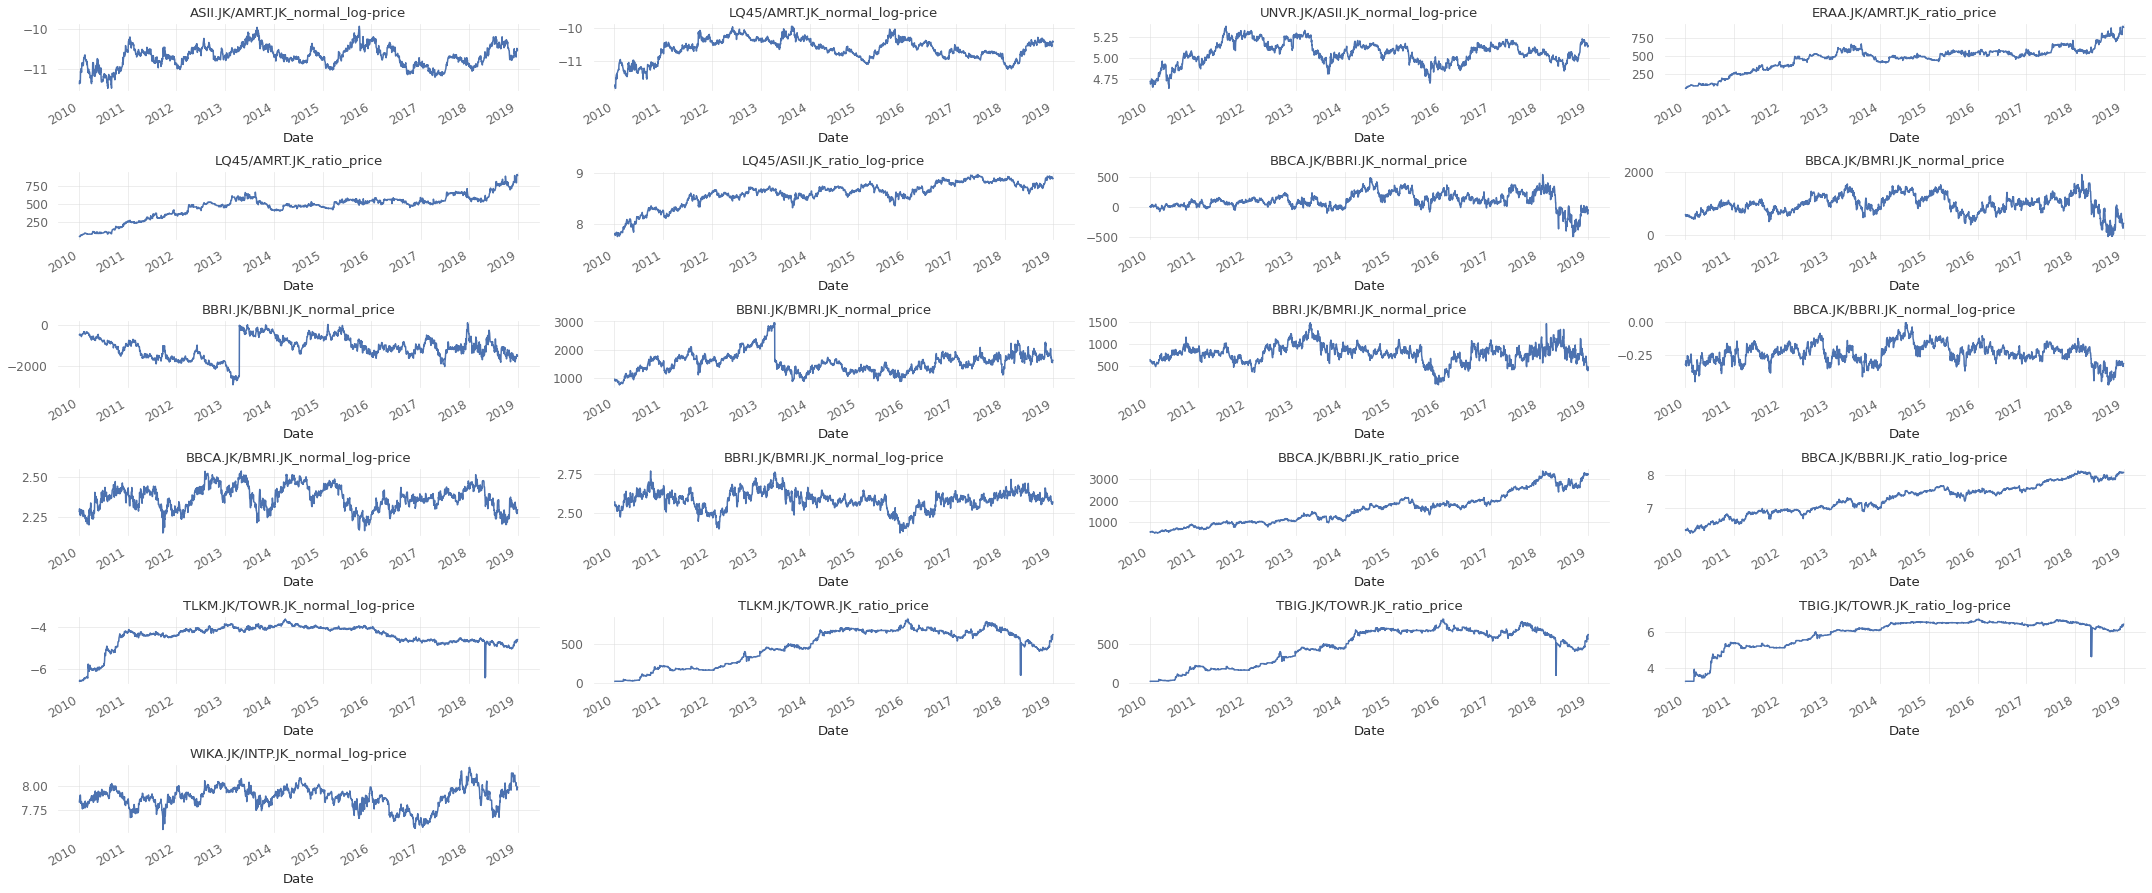

In [12]:
# Visualize Price Spread
fig = plt.figure(figsize=(30,20))

for i, row in pair_df.iterrows():
    # Combine Series
    comb_df = gen_combined_df(in_df, [row['ticker_1'], row['ticker_2']], [row['form_type']])
    S1 = comb_df[row['ticker_1'] + "_" + row['form_type']]
    S2 = comb_df[row['ticker_2'] + "_" + row['form_type']]
    
    # Calculate Spread
    spread = S2 - row['beta'] * S1
    
    # Plot on Specific Axis
    ax = plt.subplot(10, 4, i+1)
    ax.set_title(row['ticker_1'] + "/" + row['ticker_2'] + "_" + row['form'] + "_" + row['form_type'])
    spread.plot(ax=ax)

plt.tight_layout()
plt.show()

## Strategy + Backtest

### Backtest Helper Functions

In [27]:
import scipy.stats as ss

def prob_sr(ret, sr_benchmark=0):
    sr = qs.stats.sharpe(ret)
    n = len(ret)
    skew = ss.skew(ret)
    kurtosis = ss.kurtosis(ret, fisher=False)
    
    # Assuming SR is annualized, we need to change into periodical
    sr = sr/np.sqrt(252)
    sr_benchmark = sr_benchmark/np.sqrt(252)
    
    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))
    psr = ss.norm.cdf((sr - sr_benchmark) / sr_std)

    return psr

def expected_sr_max(trials_sr_std=0, num_trials=0, exp_sr_mean=0):
    emc = 0.5772156649
    max_z = (1 - emc) * ss.norm.ppf(1 - 1./num_trials) + emc * ss.norm.ppf(1 - 1./(num_trials * np.e))
    return exp_sr_mean + (trials_sr_std*max_z)

def def_sr(ret, trials_sr_df):
    sr_std = trials_sr_df.std()
    exp_sr_max = expected_sr_max(trials_sr_std=sr_std, num_trials=len(trials_sr_df))
    d_sr = prob_sr(ret, sr_benchmark=exp_sr_max)
    return d_sr

def is_recently_drawdown(s_ret, delta=4):
    '''
    Check if within the previous delta number of days there is a drawdown
    '''
    dd_details = qs.stats.drawdown_details(s_ret)
    dts = [(datetime.now() - timedelta(days=i)).strftime("%Y-%m-%d") for i in range(delta)]
    
    indicator = False
    for dt in dts:
        if dt in dd_details['end'].values:
            indicator = True
        
    return indicator

### Simple Bollinger-Band

In [149]:
from statsmodels.regression.rolling import RollingOLS

def bb_strategy(df_dict, pair_ticker, lookback, form_type='price', beta=None, beta_lookback=30, std=1):
    '''
    Long-Only Bollinger Band Mean Reversion Strategy
    
    1. Calculate the Rolling Price Spread (or use set beta), by first estimating the beta model of the pair.
       We assume the model is of the form Y = beta * X where Y is the second item in the pair.
    2. Calculate the BBands
    3. Generate Signal, based on BBand (long when price >= bbl, exit when price <= bbm)
    4. Calculate Returns
    '''
    
    # Take the relevant price series from each pair
    df_proc = gen_combined_df(df_dict, [pair_ticker[0], pair_ticker[1]], [form_type], add_pfix=False)
    pair = pair_ticker
    
    # Determine Beta
    ## Add beta / Rolling Beta to main df
    if beta is not None:
        df_proc['beta'] = beta
    else:
        S1 = df_proc[pair[0]]
        S1.name = form_type
        S2 = df_proc[pair[1]]
        S2.name = form_type
        
        S1_indep = sm.add_constant(S1)
        result = RollingOLS(S2, S1_indep, window=beta_lookback).fit()
        rolling_beta = result.params[form_type]
    
        df_proc['beta'] = rolling_beta
    
    ## calculate rolling spread
    df_proc['spread'] = df_proc[pair[1]] - df_proc['beta'] * df_proc[pair[0]]
    
    # Generate Technical Indicators (BBand)
    bbands = ta.bbands(df_proc['spread'], length=lookback, std=std)
    
    bbands_upper_cname = 'BBU' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_lower_cname = 'BBL' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_mid_cname = 'BBM' + '_' + str(lookback) + '_' + str(std) + '.0'
    
    df_proc['spread_BBU'] = bbands[bbands_upper_cname]
    df_proc['spread_BBL'] = bbands[bbands_lower_cname]
    df_proc['spread_BBM'] = bbands[bbands_mid_cname]
    
    # Signal Rules
    long_signal = lambda price, bbl: (price <= bbl)
    long_close_signal = lambda price, bbm: (price >= bbm)
    short_signal = lambda price, bbu: (price >= bbu) # note: might be better to set absolute differences   
    short_close_signal = lambda price, bbm: (price <= bbm)
    
    # Generate Signals
    ## This Signal generation is for a long-only strategy
    last_signal = ''
    df_proc['signal'] = ''
    df_proc['signal_ticker'] = ''
    for i in range(0, len(df_proc)):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['spread_BBU'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            elif short_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'long_entry':
            if long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'short_entry':
            if short_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'long_close' or last_signal == 'short_close':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['spread_BBU'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''

    return df_proc
    
def calc_strategy_returns(df, consider_trx_cost=True, buy_cost_pct=0.05, sell_cost_pct=0.1, form_type='price'):
    '''
    Calculate returns and cumulative returns per entry on dataframe.

    Strategy Returns: 
    - (Short Spread) returns(S2 Buy price, S2 Close Price). 
    - (Long Spread) returns(S1 Buy price, S1 Close Price). 
    '''
    
    df_proc = df.copy()

    last_signal = ''
    last_ticker = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'long_entry' or last_signal == 'short_entry':
            if form_type == 'price':
                df_proc["return"][i] = (df_proc[last_ticker][i] - df_proc[last_ticker][i-1]) / df_proc[last_ticker][i-1]
            elif form_type == 'log-price':
                df_proc["return"][i] = df_proc[last_ticker][i] - df_proc[last_ticker][i-1]
        elif last_signal == 'long_close' or last_signal == 'short_close':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 
            last_ticker = df_proc['signal_ticker'][i]
            
            # Add trx cost
            if consider_trx_cost:
                if df_proc["signal"][i] == 'long_entry' or df_proc["signal"][i] == 'short_entry':
                    df_proc["return"][i] -= buy_cost_pct / 100
                elif df_proc["signal"][i] == 'long_close' or df_proc["signal"][i] == 'short_close':
                    df_proc["return"][i] -= sell_cost_pct / 100

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

In [150]:
# Single Walk Forward Backtest per Pair
pair_l = []
s1_ret_arr = []
s1_df_arr = []
for i, row in pair_df.iterrows():
    # Run Strategy
    pair = [row['ticker_1'], row['ticker_2']]
    hl = row['half_life']
    
    s_df = bb_strategy(out_df, pair, round(hl), form_type=row['form_type'], std=2)
    s_df = calc_strategy_returns(s_df, form_type=row['form_type'])
    s_ret = s_df['return']
    
    s1_ret_arr.append(s_ret)
    s1_df_arr.append(s_df)
    
    # Calculate Number of Trades
    entry_trades = len(s_df[s_df['signal'] == 'long_entry']) + len(s_df[s_df['signal'] == 'short_entry'])
    close_trades = len(s_df[s_df['signal'] == 'long_close']) + len(s_df[s_df['signal'] == 'short_close'])
    num_trades = min([entry_trades, close_trades])
    
    pair_l.append({
                    '#Trades': num_trades,
                    '#Trades (Ann)': num_trades / (len(s_ret)/252),
                    'Max DD %': qs.stats.drawdown_details(s_ret)['max drawdown'].min(),
                    'Longest DD': qs.stats.drawdown_details(s_ret)['days'].max(),
                    'Currently DD?': is_recently_drawdown(s_ret, delta=4),
                    'Cumulative Return': s_df.iloc[-1]['cum_return'],
                    'CAGR': qs.stats.cagr(s_ret),
                    'Sharpe': qs.stats.sharpe(s_ret),
                    'Prob. Sharpe': prob_sr(s_ret, sr_benchmark=0.025)
                    })

# Calculate Deflated Sharpe
s1_pair_df = pd.concat([pair_df, pd.DataFrame(pair_l)], axis=1)

pair_def_sr = []
for s_ret in s1_ret_arr:
    pair_def_sr.append({'Deflated Sharpe': def_sr(s_ret, 
                                                pd.DataFrame(s1_pair_df['Sharpe'], columns=['Sharpe']))[0]
                       })

s1_pair_df = pd.concat([s1_pair_df, pd.DataFrame(pair_def_sr)], axis=1)

In [151]:
display(s1_pair_df.sort_values(by=['Cumulative Return'], ascending=False))

,index,ticker_1,ticker_2,form,form_type,eg_pvalue,beta,half_life,lambda,#Trades,#Trades (Ann),Max DD %,Longest DD,Currently DD?,Cumulative Return,CAGR,Sharpe,Prob. Sharpe,Deflated Sharpe
14,25,BBCA.JK,BBRI.JK,ratio,price,3.796320e-05,0.000000,21.382326,-0.032417,28,8.176130,-6.930696,42,True,2.114455,0.239071,1.019626,0.977528,0.584337
18,36,TBIG.JK,TOWR.JK,ratio,price,6.098125e-07,0.000000,45.072920,-0.015378,14,4.088065,-6.382991,33,False,1.900961,0.201885,0.970872,0.975674,0.547206
11,22,BBCA.JK,BBRI.JK,normal,log-price,2.376449e-04,0.988207,21.685172,-0.031964,28,8.176130,-7.182577,42,True,1.850377,0.192641,0.881906,0.953293,0.474972
15,26,BBCA.JK,BBRI.JK,ratio,log-price,2.684316e-05,0.000000,22.072695,-0.031403,28,8.176130,-7.182577,42,True,1.850377,0.192641,0.881906,0.953293,0.474972
6,17,BBCA.JK,BBRI.JK,normal,price,1.409072e-02,0.672636,28.294880,-0.024497,22,6.424102,-6.930696,37,True,1.687917,0.161675,0.759441,0.927143,0.379762
3,6,ERAA.JK,AMRT.JK,ratio,price,1.567198e-03,0.000000,52.317108,-0.013249,14,4.088065,-6.115107,52,False,1.635916,0.151315,0.739266,0.917720,0.366943
19,40,TBIG.JK,TOWR.JK,ratio,log-price,7.977244e-06,0.000000,58.344295,-0.011880,12,3.504056,-4.740223,45,False,1.448397,0.111880,0.629733,0.890199,0.281972
10,21,BBRI.JK,BMRI.JK,normal,price,1.990178e-03,1.799395,17.506681,-0.039593,32,9.344148,-12.992124,46,True,1.341178,0.087667,0.422046,0.769635,0.180382
5,12,LQ45,ASII.JK,ratio,log-price,6.540234e-03,0.000000,55.133199,-0.012572,11,3.265018,-7.410805,47,False,1.174242,0.047094,0.394792,0.751465,0.170181
9,20,BBNI.JK,BMRI.JK,normal,price,2.103186e-02,0.570617,35.747435,-0.019390,21,6.132097,-6.990295,41,True,1.052457,0.014744,0.181263,0.614746,0.085686


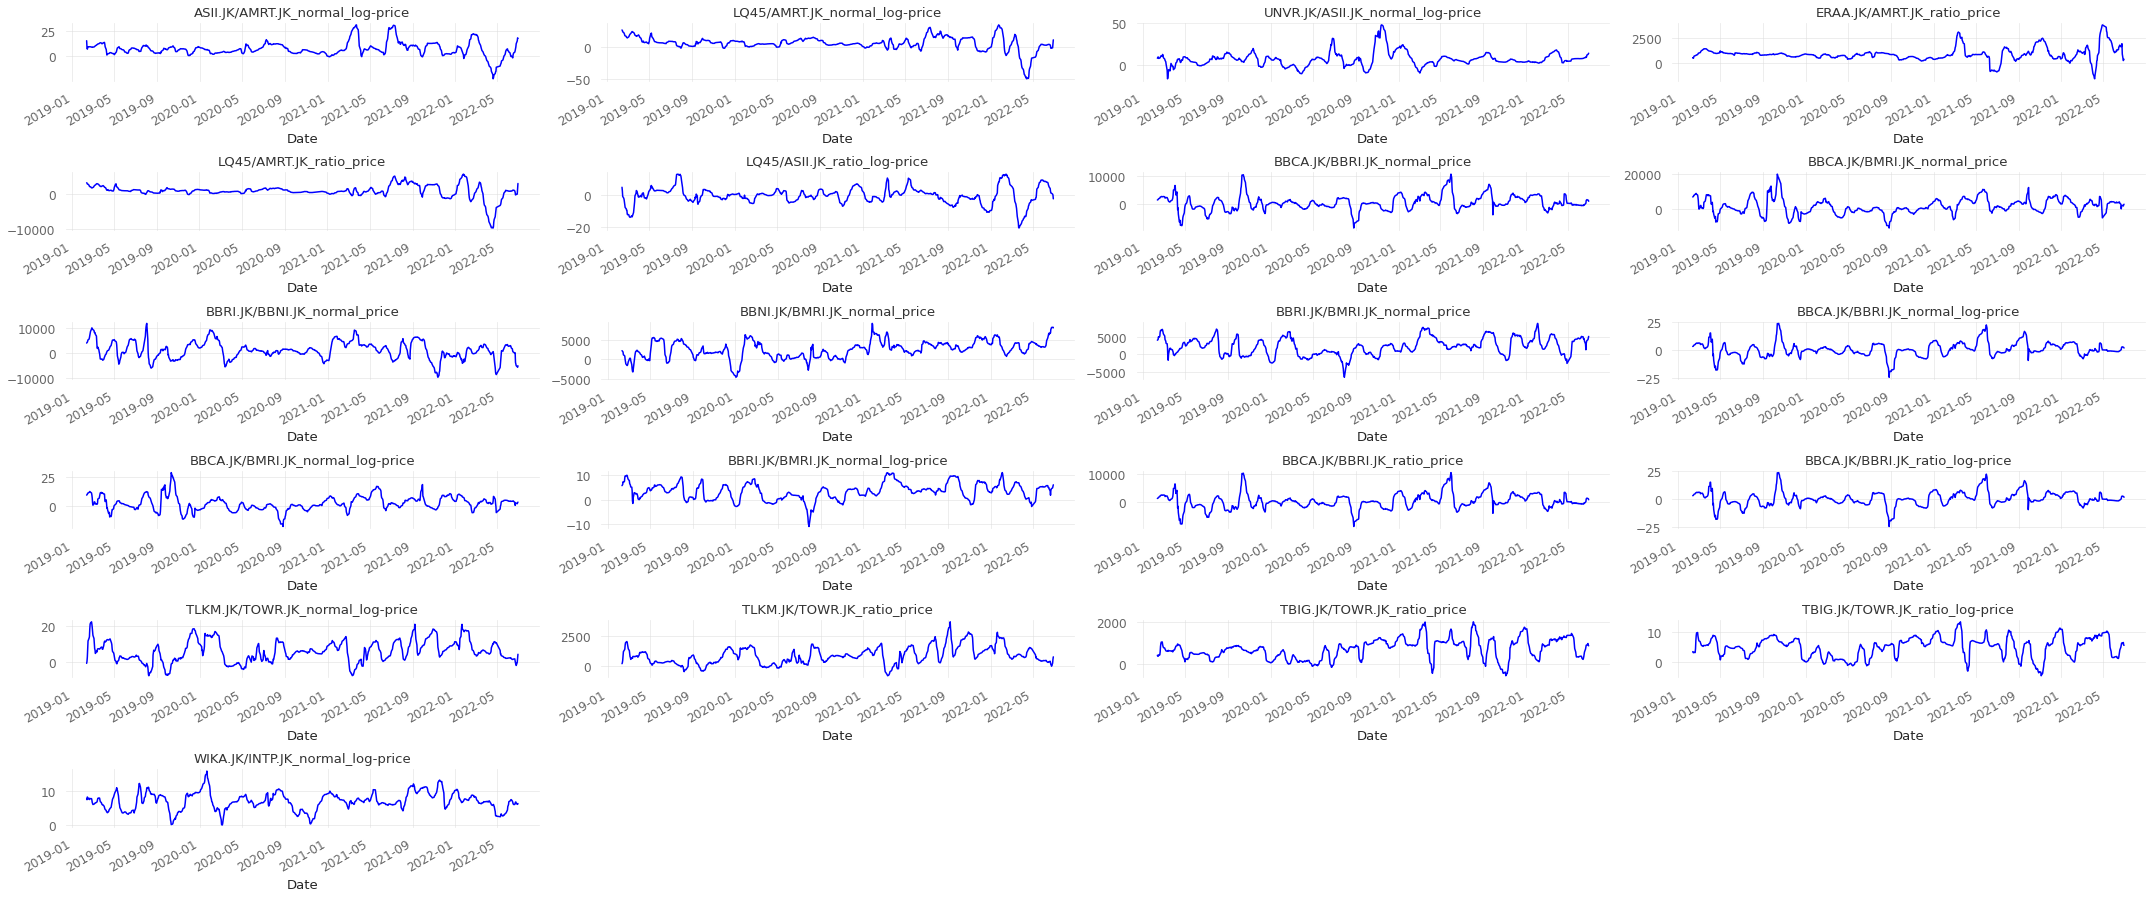

In [152]:
# Visualize Rolling Price Spread
fig = plt.figure(figsize=(30,20))

for i, row in pair_df.iterrows():
    df = s1_df_arr[i]
    df['spread'] = np.nan
    
    # Combine Series
    S1 = df.iloc[:, 0]
    S2 = df.iloc[:, 1]
    
    # Calculate Spread
    spread = S2 - df['beta'] * S1
    
    # Test Stationarity
    result = adfuller(handle_nan(spread, method='drop'))
    pvalue = result[1]
    is_stationary = (pvalue < 0.025)
    
    # Plot on Specific Axis
    ax = plt.subplot(10, 4, i+1)
    ax.set_title(row['ticker_1'] + "/" + row['ticker_2'] + "_" + row['form'] + "_" + row['form_type'])
    spread.plot(ax=ax)
    
    # Stationary Test on Spread
    if (is_stationary): 
        ax.get_lines()[0].set_color("blue") 
    else :
        ax.get_lines()[0].set_color("red")
    
plt.tight_layout()
plt.show()

### Kalman Filter

In [153]:
class HedgeRatioKFLinReg():
    # Source: https://www.quantstart.com/articles/kalman-filter-based-pairs-trading-strategy-in-qstrader/
    def __init__(self):
        # Mean of System State, or Beta/Hedge Ratio
        self.theta = np.zeros(2)
        
        # Covariance Matrix of System State
        self.R = None
        
        # Covariance Matrix of System State Noise
        self.delta = 1e-4
        self.wt = self.delta / (1 - self.delta) * np.eye(2)
        
        # Covariance Matrix of Measurement Noise
        self.vt = 1e-3
        
    def update(self, s1_price, s2_price):
        # Create the observation matrix of the latest prices
        # of TLT and the intercept value (1.0) as well as the
        # scalar value of the latest price from IEI
        F = np.asarray([s1_price, 1.0]).reshape((1, 2))
        y = s2_price

        # The prior value of the states \theta_t is
        # distributed as a multivariate Gaussian with
        # mean a_t and variance-covariance R_t
        if self.R is not None:
            self.R = self.C + self.wt
        else:
            self.R = np.zeros((2, 2))

        # Calculate the Kalman Filter update
        # ----------------------------------
        # Calculate prediction of new observation
        # as well as forecast error of that prediction
        yhat = F.dot(self.theta)
        et = y - yhat

        # Q_t is the variance of the prediction of
        # observations and hence \sqrt{Q_t} is the
        # standard deviation of the predictions
        Qt = F.dot(self.R).dot(F.T) + self.vt
        sqrt_Qt = np.sqrt(Qt)

        # The posterior value of the states \theta_t is
        # distributed as a multivariate Gaussian with mean
        # m_t and variance-covariance C_t
        At = self.R.dot(F.T) / Qt
        self.theta = self.theta + At.flatten() * et
        self.C = self.R - At * F.dot(self.R)
        
        return self.theta, sqrt_Qt, et

def kf_strategy(df_dict, pair_ticker, form_type='price', std=1, burn_in=4):
    '''
    Kalman Filter Long-Only Bollinger Band Mean Reversion Strategy
    
    1. Calculate the beta/hedge ratio, std, and price spread from KF.
       We assume the model is of the form Y = beta * X where Y is the second item in the pair.
    2. Generate Signal, based on KF std (long when price spread < -std, exit when price spread >= -std)
    3. Calculate Returns
    '''
    
    # Take the relevant price series from each pair
    df_proc = gen_combined_df(df_dict, [pair_ticker[0], pair_ticker[1]], [form_type], add_pfix=False)
    pair = pair_ticker
    
    # Calculate beta, std, price spread using KalmanFilter
    kf = HedgeRatioKFLinReg()
    S1 = df_proc[pair[0]]
    S2 = df_proc[pair[1]]
    kf_l = []
    
    for p1, p2 in zip(S1,S2):
        _, state_std, spread = kf.update(p1, p2)
        kf_l.append({
                        'std': state_std[0][0],
                        'spread': spread[0]
                    })
        
    ## Combine df
    kf_df = pd.DataFrame(kf_l)
    for col in kf_df:
        df_proc[col] = kf_df[col].values
    
    # Drop burn in periods
    df_proc = df_proc[burn_in:]
    
    # Signal Rules
    long_signal = lambda price, std: (price < -std)
    long_close_signal = lambda price, std: (price >= -std)
    short_signal = lambda price, std: (price > std)  
    short_close_signal = lambda price, std: (price <= std)
    
    # Generate Signals
    ## This Signal generation is for a long-only strategy
    last_signal = ''
    df_proc['signal'] = ''
    df_proc['signal_ticker'] = ''
    for i in range(0, len(df_proc)):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if long_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif long_close_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            elif short_close_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'long_entry':
            if long_close_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'short_entry':
            if short_close_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'short_close'
                last_signal = 'short_close'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''
                
        elif last_signal == 'long_close' or last_signal == 'short_close':
            if long_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif short_signal(df_proc['spread'][i], df_proc['std'][i]):
                df_proc['signal'][i] = 'short_entry'
                last_signal = 'short_entry'
                df_proc['signal_ticker'][i] = pair[0]
            else:
                df_proc['signal'][i] = ''

    return df_proc

In [154]:
# Single Walk Forward Backtest per Pair
pair_l = []
s2_ret_arr = []
s2_df_arr = []
for i, row in pair_df.iterrows():
    # Run Strategy
    pair = [row['ticker_1'], row['ticker_2']]
    hl = row['half_life']
    
    s_df = kf_strategy(out_df, pair, form_type=row['form_type'])
    s_df = calc_strategy_returns(s_df, form_type=row['form_type'])
    s_ret = s_df['return']
    
    s2_ret_arr.append(s_ret)
    s2_df_arr.append(s_df)
    
    # Calculate Number of Trades
    entry_trades = len(s_df[s_df['signal'] == 'long_entry']) + len(s_df[s_df['signal'] == 'short_entry'])
    close_trades = len(s_df[s_df['signal'] == 'long_close']) + len(s_df[s_df['signal'] == 'short_close'])
    num_trades = min([entry_trades, close_trades])
    
    pair_l.append({
                    '#Trades': num_trades,
                    '#Trades (Ann)': num_trades / (len(s_ret)/252),
                    'Max DD %': qs.stats.drawdown_details(s_ret)['max drawdown'].min(),
                    'Longest DD': qs.stats.drawdown_details(s_ret)['days'].max(),
                    'Currently DD?': is_recently_drawdown(s_ret, delta=4),
                    'Cumulative Return': s_df.iloc[-1]['cum_return'],
                    'CAGR': qs.stats.cagr(s_ret),
                    'Sharpe': qs.stats.sharpe(s_ret),
                    'Prob. Sharpe': prob_sr(s_ret, sr_benchmark=0.025)
                    })

# Calculate Deflated Sharpe
s2_pair_df = pd.concat([pair_df, pd.DataFrame(pair_l)], axis=1)

pair_def_sr = []
for s_ret in s2_ret_arr:
    pair_def_sr.append({'Deflated Sharpe': def_sr(s_ret, 
                                                pd.DataFrame(s2_pair_df['Sharpe'], columns=['Sharpe']))[0]
                       })

s2_pair_df = pd.concat([s2_pair_df, pd.DataFrame(pair_def_sr)], axis=1)

In [155]:
display(s2_pair_df.sort_values(by=['Cumulative Return'], ascending=False))

,index,ticker_1,ticker_2,form,form_type,eg_pvalue,beta,half_life,lambda,#Trades,#Trades (Ann),Max DD %,Longest DD,Currently DD?,Cumulative Return,CAGR,Sharpe,Prob. Sharpe,Deflated Sharpe
3,6,ERAA.JK,AMRT.JK,ratio,price,1.567198e-03,0.000000,52.317108,-0.013249,309,90.649593,-14.864867,141,True,3.027608,0.375238,0.994654,0.967035,4.890007e-01
18,36,TBIG.JK,TOWR.JK,ratio,price,6.098125e-07,0.000000,45.072920,-0.015378,246,72.167637,-9.192208,51,True,2.761433,0.339315,1.168557,0.989692,6.265013e-01
7,18,BBCA.JK,BMRI.JK,normal,price,2.017986e-02,1.214822,30.314143,-0.022865,264,77.448196,-7.090295,30,True,1.653129,0.155556,0.764910,0.927653,3.150659e-01
10,21,BBRI.JK,BMRI.JK,normal,price,1.990178e-03,1.799395,17.506681,-0.039593,300,88.009313,-7.090295,58,True,1.559469,0.136333,0.644346,0.876340,2.477763e-01
8,19,BBRI.JK,BBNI.JK,normal,price,2.439977e-02,2.988737,37.860976,-0.018308,296,86.835856,-11.718756,59,True,1.474711,0.118214,0.559327,0.837858,2.033014e-01
14,25,BBCA.JK,BBRI.JK,ratio,price,3.796320e-05,0.000000,21.382326,-0.032417,166,48.698487,-9.092480,24,True,1.460664,0.115140,0.652174,0.898055,2.347601e-01
6,17,BBCA.JK,BBRI.JK,normal,price,1.409072e-02,0.672636,28.294880,-0.024497,166,48.698487,-9.092480,24,True,1.460664,0.115140,0.652174,0.898055,2.347601e-01
4,7,LQ45,AMRT.JK,ratio,price,1.315999e-03,0.000000,48.088961,-0.014414,265,79.029586,-8.261279,46,True,1.330344,0.085634,0.467290,0.798121,1.531600e-01
17,35,TLKM.JK,TOWR.JK,ratio,price,6.733976e-13,0.000000,38.705515,-0.017908,90,26.402794,-6.647399,13,True,1.136887,0.037590,0.320381,0.716322,9.114168e-02
5,12,LQ45,ASII.JK,ratio,log-price,6.540234e-03,0.000000,55.133199,-0.012572,2,0.596450,-0.100000,4,False,1.122984,0.033952,0.563390,0.978333,4.716244e-02


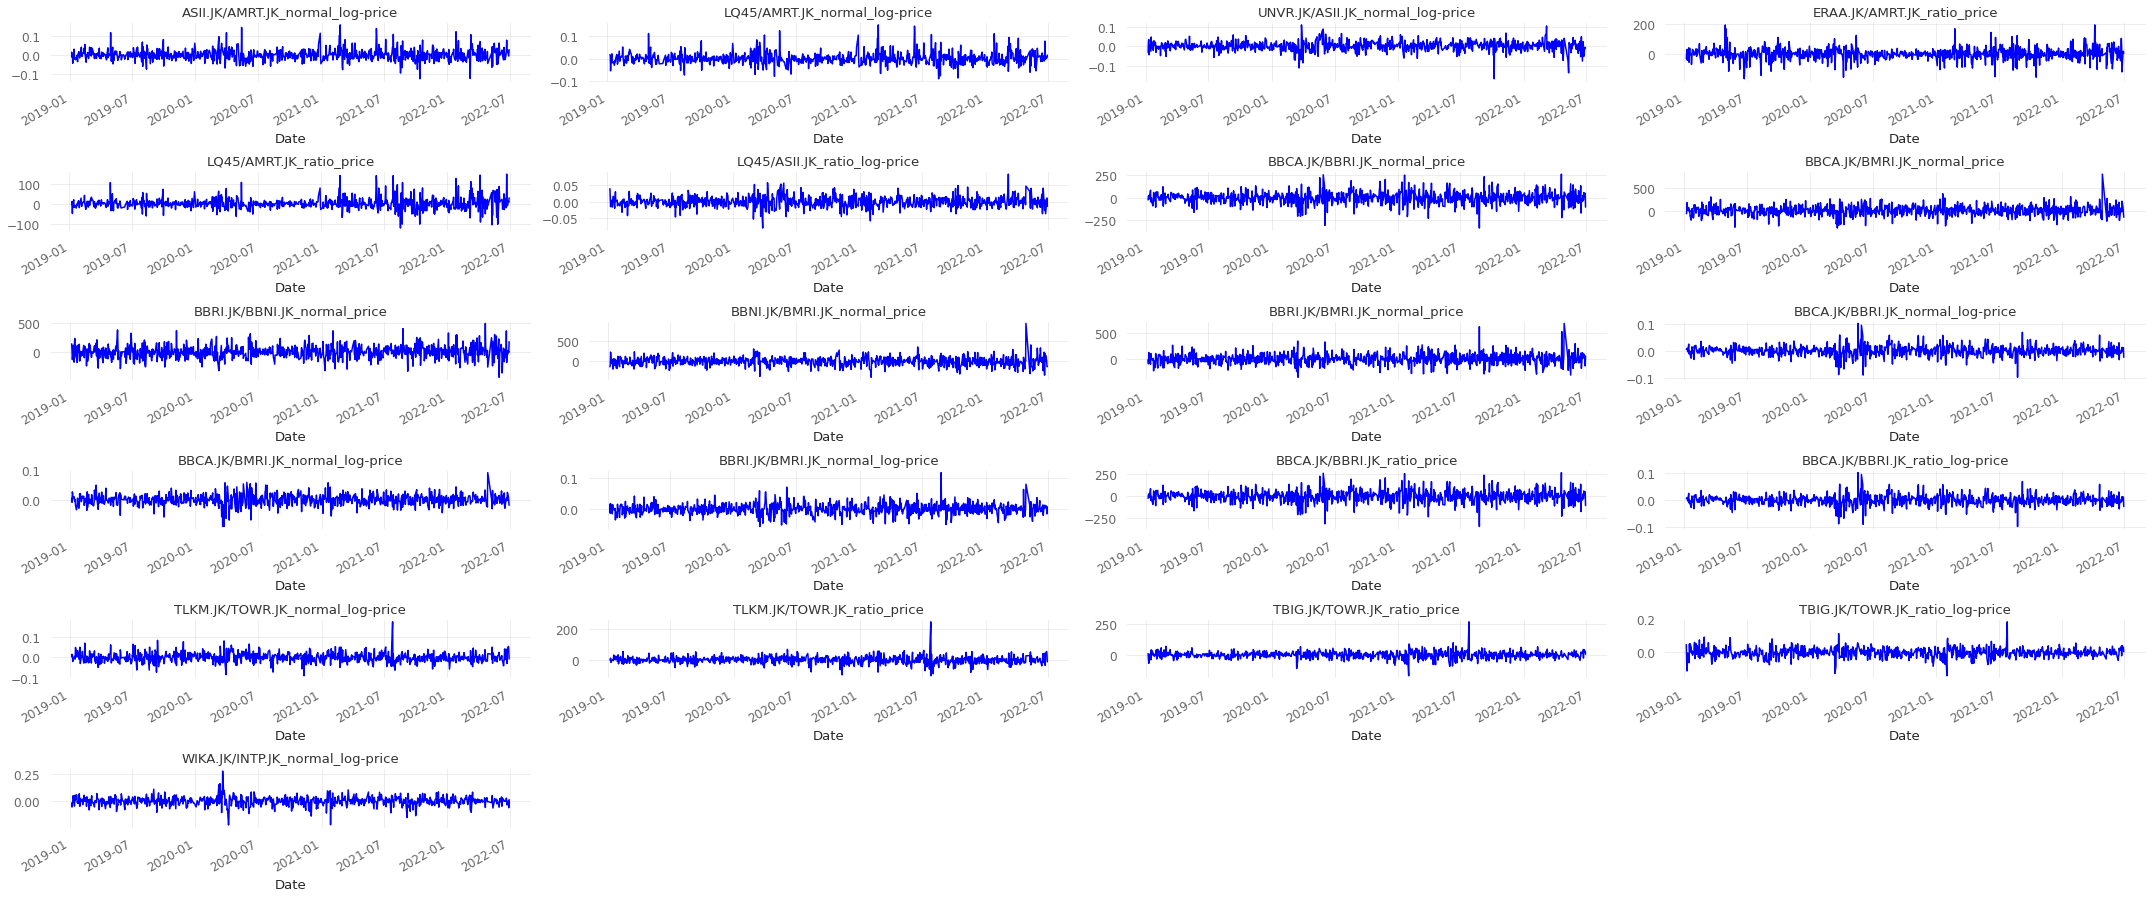

In [156]:
# Visualize Rolling Price Spread
fig = plt.figure(figsize=(30,20))

for i, row in pair_df.iterrows():
    df = s2_df_arr[i]
    # Calculate Spread
    spread = df['spread']
    
    # Test Stationarity
    result = adfuller(handle_nan(spread, method='drop'))
    pvalue = result[1]
    is_stationary = (pvalue < 0.025)
    
    # Plot on Specific Axis
    ax = plt.subplot(10, 4, i+1)
    ax.set_title(row['ticker_1'] + "/" + row['ticker_2'] + "_" + row['form'] + "_" + row['form_type'])
    spread.plot(ax=ax)
    
    # Stationary Test on Spread
    if (is_stationary): 
        ax.get_lines()[0].set_color("blue") 
    else :
        ax.get_lines()[0].set_color("red")

plt.tight_layout()
plt.show()